# **The Problem & Business Importance**





# **Data Identification & Analysis**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import joblib

from KNN_D import KNN_D

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV,train_test_split , KFold
from sklearn.linear_model import LogisticRegression , RidgeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.svm import SVC
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('i4talent_dataset.csv')
df['datum'] = pd.to_datetime(df['datum'])
df['geboortedatum'] = pd.to_datetime(df['geboortedatum'])
df['indiensttreding_datum'] = pd.to_datetime(df['indiensttreding_datum'])


In [3]:
df.head()

,WerknemerID,datum,geboortedatum,indiensttreding_datum,uitdiensttreding_datum,leeftijd,lengte_dienst,stad,afdeling,klant_id,geslacht_id,geslacht,uitdiensttreding_reden,uitdiensttreding_type,STATUS_JAAR,STATUS,BUSINESS_UNIT
0,6962,2018-12-31 05:06:00,1989-06-26 05:06:00,2013-05-23 05:06:00,1905-01-01 05:06:00,29.0,5.0,Amstelveen,BI,30,V,Vrouw,Niet van toepassing,Niet van toepassing,2018,Actief,Detachering
1,6212,2016-12-30 05:06:00,1983-08-25 05:06:00,2010-04-24 05:06:00,1905-01-01 05:06:00,33.0,6.0,Utrecht,Accountant,21,M,Man,Niet van toepassing,Niet van toepassing,2016,Actief,Detachering
2,5325,2018-12-31 05:06:00,1976-04-24 05:06:00,2006-06-09 05:06:00,1905-01-01 05:06:00,42.0,12.0,Amsterdam,BI,42,V,Vrouw,Niet van toepassing,Niet van toepassing,2018,Actief,Detachering
3,8193,2018-12-31 05:06:00,1998-10-26 05:06:00,2018-04-28 05:06:00,1905-01-01 05:06:00,20.0,NaN,Utrecht,BI,21,V,Vrouw,Niet van toepassing,Niet van toepassing,2018,Actief,Detachering
4,5926,2013-12-31 05:06:00,1981-03-19 05:06:00,2009-01-09 05:06:00,1905-01-01 05:06:00,32.0,4.0,Den Haag,Accountant,18,M,Man,Niet van toepassing,Niet van toepassing,2013,Actief,Detachering


In [4]:
df.describe()

,WerknemerID,datum,geboortedatum,indiensttreding_datum,leeftijd,lengte_dienst,klant_id,STATUS_JAAR
count,49753.000000,49753,49753,49753,44653.000000,44802.000000,49753.000000,49753.000000
mean,4859.473600,2016-08-06 00:21:52.006914304,1974-01-10 05:10:34.379434400,2005-09-04 11:13:13.710530176,42.046223,10.442592,27.296525,2015.612566
min,1318.000000,2011-01-01 05:06:00,1946-01-15 05:06:00,1994-08-28 05:06:00,19.000000,0.000000,1.000000,2011.000000
25%,3360.000000,2013-12-31 05:06:00,1963-05-28 05:06:00,2000-06-01 05:06:00,31.000000,5.000000,16.000000,2013.000000
50%,5031.000000,2016-12-30 05:06:00,1973-12-04 05:06:00,2005-03-31 05:06:00,42.000000,10.000000,28.000000,2016.000000
75%,6335.000000,2018-12-31 05:06:00,1984-07-17 05:06:00,2010-10-13 05:06:00,53.000000,15.000000,42.000000,2018.000000
max,8336.000000,2020-12-30 05:06:00,1999-12-31 05:06:00,2018-12-11 05:06:00,65.000000,26.000000,46.000000,2020.000000
std,1827.113618,NaN,NaN,NaN,12.424199,6.326893,13.512861,2.845621


In [5]:
print(df.isna().sum())

WerknemerID                  0
datum                        0
geboortedatum                0
indiensttreding_datum        0
uitdiensttreding_datum       0
leeftijd                  5100
lengte_dienst             4951
stad                      5543
afdeling                  5065
klant_id                     0
geslacht_id                  0
geslacht                     0
uitdiensttreding_reden       0
uitdiensttreding_type        0
STATUS_JAAR                  0
STATUS                       0
BUSINESS_UNIT                0
dtype: int64


In [6]:
df['leeftijd'] = df['leeftijd'].fillna((df['datum'] - df['geboortedatum']).dt.days // 365)
df['lengte_dienst'] = df['lengte_dienst'].fillna((df['datum'] - df['indiensttreding_datum']).dt.days // 365)
df['stad'] = df['stad'].fillna(df['stad'].mode())
df['afdeling'] = df['afdeling'].fillna(df['afdeling'].mode())

print(df.isna().sum())

WerknemerID                  0
datum                        0
geboortedatum                0
indiensttreding_datum        0
uitdiensttreding_datum       0
leeftijd                     0
lengte_dienst                0
stad                      5543
afdeling                  5065
klant_id                     0
geslacht_id                  0
geslacht                     0
uitdiensttreding_reden       0
uitdiensttreding_type        0
STATUS_JAAR                  0
STATUS                       0
BUSINESS_UNIT                0
dtype: int64


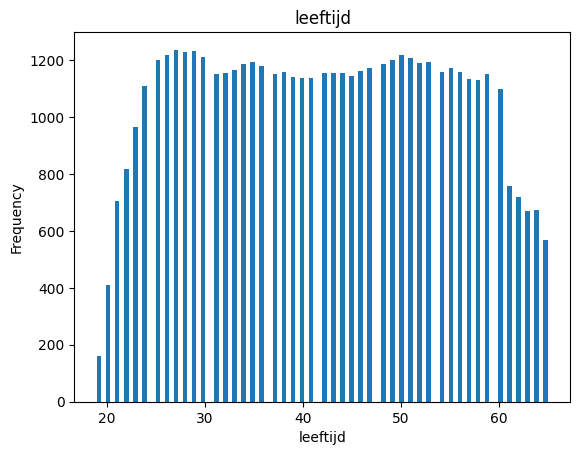

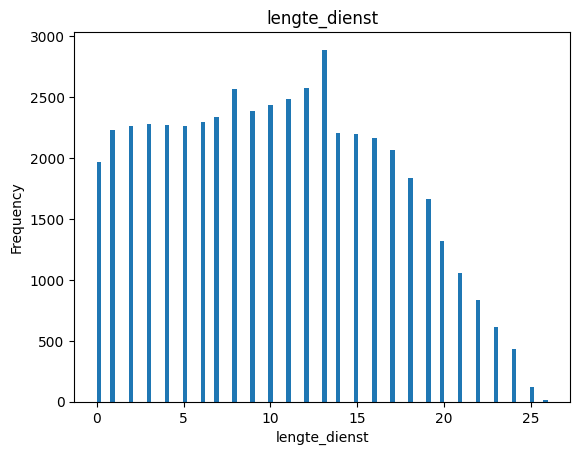

In [7]:
columns_numerical_with_nas = ['leeftijd', 'lengte_dienst']
for col in columns_numerical_with_nas:
    plt.hist(df[col], bins=100)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [8]:
columns_to_delete = ['geboortedatum', 'WerknemerID', 'uitdiensttreding_datum', 'indiensttreding_datum', 'geslacht', 'uitdiensttreding_type', 'datum', 'STATUS_JAAR', 'uitdiensttreding_reden']
df_new = df.drop(columns=columns_to_delete)


In [9]:
df_with_dummies = pd.get_dummies(df_new, columns=['stad', 'afdeling', 'geslacht_id', 'STATUS', 'BUSINESS_UNIT'], drop_first=True , dtype = int)
df_with_dummies.columns

Index(['leeftijd', 'lengte_dienst', 'klant_id', 'stad_Almere',
       'stad_Alphen aan den Rijn', 'stad_Amstelveen', 'stad_Amsterdam',
       'stad_Barendrecht', 'stad_Breda', 'stad_Capelle', 'stad_Delft',
       'stad_Den Haag', 'stad_Dordrecht', 'stad_Eindhoven', 'stad_Gouda',
       'stad_Haarlem', 'stad_Hoogeveen', 'stad_Leiden', 'stad_Lelystad',
       'stad_Middelburg', 'stad_Pijnacker', 'stad_Rijswijk', 'stad_Roermond',
       'stad_Rotterdam', 'stad_Schiedam', 'stad_Tilburg', 'stad_Utrecht',
       'stad_Veenendaal', 'stad_Woerden', 'stad_Zaandam', 'stad_Zeist',
       'stad_Zoetermeer', 'afdeling_Administratief medewerker', 'afdeling_BI',
       'afdeling_Boekhouder', 'afdeling_Business analist',
       'afdeling_Business controller', 'afdeling_Business development',
       'afdeling_Credit controller', 'afdeling_Financial controller',
       'afdeling_HR', 'afdeling_IT', 'afdeling_Legal', 'afdeling_Marketing',
       'afdeling_Office manager', 'afdeling_Project controller',
 

geboortedatum, WerknemerID, uitdiensttreding_datum, indiensttreding_datum, geslacht, uitdiensttreding_type

Dummies: 'stad', 'afdeling', 'geslachtID', 'uitdiensttreding_reden', 'Status', 'BUSINESS_UNIT'

In [10]:
#Used later for model evaluation
model_scores = {}

#You can download the pretrained models here : https://github.com/dvanaanhout/GROUP5
#Saves time running the file.

In [11]:
X = df_with_dummies.drop(columns=['STATUS_Beëindigd'])
y = df_with_dummies['STATUS_Beëindigd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:

saved_model_name = 'model_lr.joblib'

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_lr = loaded_model
else:
    model_lr = LogisticRegression()
    model_lr.fit(X_train, y_train)
    joblib.dump(model_lr, saved_model_name)

y_pred = model_lr.predict(X_test)

params = model_lr.get_params()
train_score = model_lr.score(X_train, y_train)
test_score = model_lr.score(X_test, y_test)


model_scores['Logistic Regression'] = {
    'Train Score': train_score,
    'Test Score': test_score,
    'Used parameters' : params
}


conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")
print("Confusion Matrix:")
print(conf_matrix)
print(classification_report(y_test, y_pred))



Train Score: 0.9695743932465706
Test Score: 0.9692493216762135
Confusion Matrix:
[[9640   20]
 [ 286    5]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      9660
           1       0.20      0.02      0.03       291

    accuracy                           0.97      9951
   macro avg       0.59      0.51      0.51      9951
weighted avg       0.95      0.97      0.96      9951



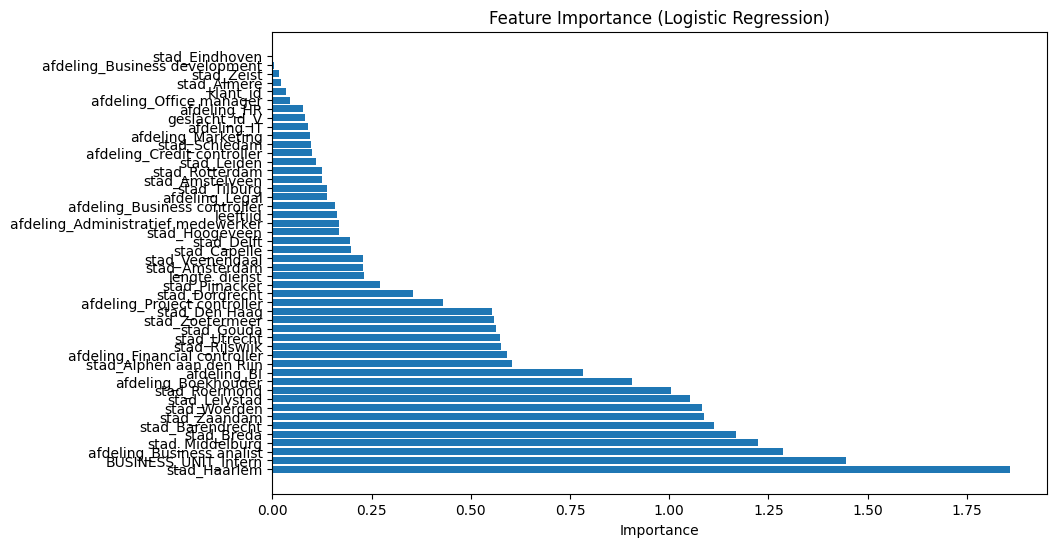

In [13]:
coefficients = model_lr.coef_[0]

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients,
    'Importance': np.abs(coefficients)
})

feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance (Logistic Regression)')
plt.show()

In [14]:
saved_model_name = 'model_lr_TUNED.joblib'

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
}

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_lr_TUNED = loaded_model
else:
    grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    model_lr_TUNED = grid_search.best_estimator_
    joblib.dump(model_lr_TUNED, saved_model_name)

y_pred = model_lr_TUNED.predict(X_test)

train_score = model_lr_TUNED.score(X_train, y_train)
test_score = model_lr_TUNED.score(X_test, y_test)

params = model_lr_TUNED.get_params()

model_scores['Logistic Regression TUNED'] = {
    'Train Score': train_score,
    'Test Score': test_score,
    'Used parameters' : params
}

conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")
print("Confusion Matrix:")
print(conf_matrix)
print(classification_report(y_test, y_pred))

Train Score: 0.9700015074619366
Test Score: 0.9705557230429103
Confusion Matrix:
[[9658    2]
 [ 291    0]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      9660
           1       0.00      0.00      0.00       291

    accuracy                           0.97      9951
   macro avg       0.49      0.50      0.49      9951
weighted avg       0.94      0.97      0.96      9951



In [15]:
saved_model_name = 'model_HGBC.joblib'

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_hgb = loaded_model

else:
    model_hgb = HistGradientBoostingClassifier()
    model_hgb.fit(X_train, y_train)
    joblib.dump(model_hgb, saved_model_name)


y_pred = model_hgb.predict(X_test)

train_score = model_hgb.score(X_train, y_train)
test_score = model_hgb.score(X_test, y_test)

params = model_hgb.get_params()

model_scores['Hist Gradient Boosting'] = {
    'Train Score': train_score,
    'Test Score': test_score,
    'Used parameters' : params
}

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")
print(classification_report(y_test, y_pred))

Train Score: 0.9877644339480428
Test Score: 0.986835493920209
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9660
           1       0.96      0.57      0.72       291

    accuracy                           0.99      9951
   macro avg       0.97      0.79      0.86      9951
weighted avg       0.99      0.99      0.99      9951



In [16]:
saved_model_name = 'model_HGBC_TUNED.joblib'

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_HGBC_TUNED = loaded_model
else:
    model_HGBC_TUNED = HistGradientBoostingClassifier()
    param_grid = {
        'max_iter': [100, 200,300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7, 9, 21, 25],
        'min_samples_leaf': [1, 5, 10, 15, 20]
    }

    grid_search = GridSearchCV(estimator=model_HGBC_TUNED, param_grid=param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model_HGBC_TUNED = grid_search.best_estimator_
    joblib.dump(best_model_HGBC_TUNED, saved_model_name)
    model_HGBC_TUNED = best_model_HGBC_TUNED

y_pred = model_HGBC_TUNED.predict(X_test)

train_score = model_HGBC_TUNED.score(X_train, y_train)
test_score = model_HGBC_TUNED.score(X_test, y_test)

params = model_HGBC_TUNED.get_params()

model_scores['Hist Gradient Boosting TUNED'] = {
    'Train Score': train_score,
    'Test Score': test_score,
    'Used parameters' : params
}

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")

print(classification_report(y_test, y_pred))

Train Score: 0.9876639364856037
Test Score: 0.9867350015073862
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9660
           1       0.95      0.58      0.72       291

    accuracy                           0.99      9951
   macro avg       0.97      0.79      0.86      9951
weighted avg       0.99      0.99      0.99      9951



In [17]:
saved_model_name = 'model_KNN.joblib'

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_knn = loaded_model
else:
    model_knn = KNeighborsClassifier()
    model_knn.fit(X_train, y_train)
    joblib.dump(model_knn, saved_model_name)

y_pred = model_knn.predict(X_test)

train_score = model_knn.score(X_train, y_train)
test_score = model_knn.score(X_test, y_test)

params = model_knn.get_params()

model_scores['KNN'] = {
    'Train Score': train_score,
    'Test Score': test_score,
    'Used parameters' : params
}

conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")
print(classification_report(y_test, y_pred))

Train Score: 0.9855032410431637
Test Score: 0.9830167822329414
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9660
           1       0.82      0.53      0.65       291

    accuracy                           0.98      9951
   macro avg       0.91      0.76      0.82      9951
weighted avg       0.98      0.98      0.98      9951



In [18]:

saved_model_name = 'model_KNN_TUNED.joblib'

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11]
}

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_knn_TUNED = loaded_model
else:
    grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    model_knn_TUNED = grid_search.best_estimator_
    print(f"Best Parameters: {grid_search.best_params_}")
    joblib.dump(model_knn_TUNED, saved_model_name)

y_pred = model_knn_TUNED.predict(X_test)

train_score = model_knn_TUNED.score(X_train, y_train)
test_score = model_knn_TUNED.score(X_test, y_test)

params = model_knn_TUNED.get_params()

model_scores['KNN TUNED'] = {
    'Train Score': train_score,
    'Test Score': test_score,
    'Used parameters' : params
}

conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")

print(classification_report(y_test, y_pred))

Train Score: 0.9855032410431637
Test Score: 0.9830167822329414
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9660
           1       0.82      0.53      0.65       291

    accuracy                           0.98      9951
   macro avg       0.91      0.76      0.82      9951
weighted avg       0.98      0.98      0.98      9951



In [ ]:
model_KNN_D = KNN_D()
model_KNN_D.fit(X_train, y_train)


y_train_pred = model_KNN_D.predict(X_train)
y_test_pred = model_KNN_D.predict(X_test)


train_score = accuracy_score(y_train, y_train_pred)
test_score = accuracy_score(y_test, y_test_pred)

model_scores['KNN_D'] = {
    'Train Score': train_score,
    'Test Score': test_score,
    'Used parameters' : 'dcalc = Euclidean , NN = 5'
}

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Train Score: 0.9859052308929199
Test Score: 0.9826148125816501
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9660
           1       0.82      0.53      0.65       291

    accuracy                           0.98      9951
   macro avg       0.91      0.76      0.82      9951
weighted avg       0.98      0.98      0.98      9951



In [20]:
saved_model_name = 'model_XGBoost.joblib'


if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_xgboost = loaded_model
else:
    model_xgboost = XGBClassifier()
    model_xgboost.fit(X_train, y_train)
    print(f"Model Parameters: {model_xgboost.get_params()}")
    joblib.dump(model_xgboost, saved_model_name)

y_pred = model_xgboost.predict(X_test)

train_score = model_xgboost.score(X_train, y_train)
test_score = model_xgboost.score(X_test, y_test)

params = model_xgboost.get_params()

model_scores['XGBoost Classifier'] = {
    'Train Score': train_score,
    'Test Score': test_score,
    'Used parameters' : params
}

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")

print(classification_report(y_test, y_pred))

Train Score: 0.9887694085724336
Test Score: 0.9863330318560949
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9660
           1       0.92      0.58      0.71       291

    accuracy                           0.99      9951
   macro avg       0.96      0.79      0.85      9951
weighted avg       0.99      0.99      0.98      9951



In [21]:
saved_model_name = 'model_XGBoost_TUNED.joblib'

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_xgboost_TUNED = loaded_model
else:
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    grid_search = GridSearchCV(XGBClassifier(), param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    model_xgboost_TUNED = grid_search.best_estimator_
    joblib.dump(model_xgboost_TUNED, saved_model_name)

y_pred = model_xgboost_TUNED.predict(X_test)

train_score = model_xgboost_TUNED.score(X_train, y_train)
test_score = model_xgboost_TUNED.score(X_test, y_test)

params = model_xgboost_TUNED.get_params()

model_scores['XGBoost Classifier TUNED'] = {
    'Train Score': train_score,
    'Test Score': test_score,
    'Used parameters' : params
}

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")

print(classification_report(y_test, y_pred))

Train Score: 0.9865584643987739
Test Score: 0.9869359863330318
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9660
           1       0.98      0.56      0.72       291

    accuracy                           0.99      9951
   macro avg       0.98      0.78      0.85      9951
weighted avg       0.99      0.99      0.99      9951



In [22]:
saved_model_name = 'model_ridge.joblib'

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_ridge = loaded_model
else:
    model_ridge = RidgeClassifier()
    model_ridge.fit(X_train, y_train)
    joblib.dump(model_ridge, saved_model_name)


y_pred = model_ridge.predict(X_test)

train_score = model_ridge.score(X_train, y_train)
test_score = model_ridge.score(X_test, y_test)

params = model_ridge.get_params()

model_scores['Ridge Classifier'] = {
    'Train Score': train_score,
    'Test Score': test_score,
    'Used parameters' : params
}

conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Train Score: 0.9699512587307171
Test Score: 0.970756707868556
Confusion Matrix:
[[9660    0]
 [ 291    0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      9660
           1       0.00      0.00      0.00       291

    accuracy                           0.97      9951
   macro avg       0.49      0.50      0.49      9951
weighted avg       0.94      0.97      0.96      9951



c:\Users\dvana\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 1.4.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\dvana\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RidgeClassifier from version 1.4.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\dvana\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision

In [23]:
saved_model_name = 'model_ridge_TUNED.joblib'

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_ridge_TUNED = loaded_model
else:
    model_ridge_TUNED = RidgeClassifier()
    model_ridge_TUNED.fit(X_train, y_train)
    joblib.dump(model_ridge_TUNED, saved_model_name)

param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']
}

y_pred = model_ridge_TUNED.predict(X_test)

train_score = model_ridge_TUNED.score(X_train, y_train)
test_score = model_ridge_TUNED.score(X_test, y_test)

params = model_ridge_TUNED.get_params()

model_scores['Ridge Classifier TUNED'] = {
    'Train Score': train_score,
    'Test Score': test_score,
    'Used parameters' : params
}

conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Train Score: 0.9699512587307171
Test Score: 0.970756707868556
Confusion Matrix:
[[9660    0]
 [ 291    0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      9660
           1       0.00      0.00      0.00       291

    accuracy                           0.97      9951
   macro avg       0.49      0.50      0.49      9951
weighted avg       0.94      0.97      0.96      9951



c:\Users\dvana\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 1.4.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\dvana\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RidgeClassifier from version 1.4.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\dvana\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision

In [24]:
saved_model_name = 'model_lasso_classifier.joblib'

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_lasso_classifier = loaded_model
else:
    model_lasso_classifier = LogisticRegression(penalty='l1', solver='saga', max_iter=1000)
    model_lasso_classifier.fit(X_train, y_train)
    joblib.dump(model_lasso_classifier, saved_model_name)


y_pred = model_lasso_classifier.predict(X_test)

train_score = model_lasso_classifier.score(X_train, y_train)
test_score = model_lasso_classifier.score(X_test, y_test)

params = model_lasso_classifier.get_params()

model_scores['Lasso Classifier'] = {
    'Train Score': train_score,
    'Test Score': test_score,
    'Used parameters' : params
}

conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Train Score: 0.9694990201497412
Test Score: 0.9693498140890363
Confusion Matrix:
[[9642   18]
 [ 287    4]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      9660
           1       0.18      0.01      0.03       291

    accuracy                           0.97      9951
   macro avg       0.58      0.51      0.50      9951
weighted avg       0.95      0.97      0.96      9951



In [25]:
saved_model_name = 'model_lasso_classifier_TUNED.joblib'

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_lasso_classifier_TUNED = loaded_model
else:
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'max_iter': [1000, 2000]
    }
    base_model = LogisticRegression(penalty='l1', solver='saga')
    grid_search = GridSearchCV(base_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    model_lasso_classifier_TUNED = grid_search.best_estimator_
    joblib.dump(model_lasso_classifier_TUNED, saved_model_name)


y_pred = model_lasso_classifier_TUNED.predict(X_test)

train_score = model_lasso_classifier_TUNED.score(X_train, y_train)
test_score = model_lasso_classifier_TUNED.score(X_test, y_test)

params = model_lasso_classifier_TUNED.get_params()

model_scores['Lasso Classifier TUNED'] = {
    'Train Score': train_score,
    'Test Score': test_score,
    'Used parameters' : params
}

conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Train Score: 0.9699512587307171
Test Score: 0.970756707868556
Confusion Matrix:
[[9660    0]
 [ 291    0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      9660
           1       0.00      0.00      0.00       291

    accuracy                           0.97      9951
   macro avg       0.49      0.50      0.49      9951
weighted avg       0.94      0.97      0.96      9951



c:\Users\dvana\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dvana\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dvana\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [26]:
saved_model_name = 'model_DTC.joblib'

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_DTC = loaded_model
else:
    model_DTC = DecisionTreeClassifier(random_state=42)
    model_DTC.fit(X_train, y_train)
    joblib.dump(model_DTC, saved_model_name)

y_pred = model_DTC.predict(X_test)

train_score = model_DTC.score(X_train, y_train)
test_score = model_DTC.score(X_test, y_test)

params = model_DTC.get_params()

model_scores['Decision Tree Classifier'] = {
    'Train Score': train_score,
    'Test Score': test_score,
    'Used parameters' : params
}

conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(conf_matrix)

Train Score: 0.9934425405758505
Test Score: 0.9827153049944729
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9660
           1       0.74      0.63      0.68       291

    accuracy                           0.98      9951
   macro avg       0.86      0.81      0.84      9951
weighted avg       0.98      0.98      0.98      9951

Confusion Matrix:
[[9596   64]
 [ 108  183]]


In [27]:
saved_model_name = 'model_DTC_TUNED.joblib'

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_DT_TUNED = loaded_model
else:
    param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    model_DT_TUNED = DecisionTreeClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=model_DT_TUNED, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    model_DT_TUNED = grid_search.best_estimator_
    joblib.dump(model_DT_TUNED, saved_model_name)

y_pred = model_DT_TUNED.predict(X_test)

train_score = model_DT_TUNED.score(X_train, y_train)
test_score = model_DT_TUNED.score(X_test, y_test)

params = model_DT_TUNED.get_params()

model_scores['Decision Tree Classifier TUNED'] = {
    'Train Score': train_score,
    'Test Score': test_score,
    'Used parameters' : params
}

conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(conf_matrix)

Train Score: 0.9883674187226773
Test Score: 0.986232539443272
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9660
           1       0.92      0.58      0.71       291

    accuracy                           0.99      9951
   macro avg       0.96      0.79      0.85      9951
weighted avg       0.99      0.99      0.98      9951

Confusion Matrix:
[[9646   14]
 [ 123  168]]


In [28]:
saved_model_name = 'model_RandomForestClassifier.joblib'

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_RF = loaded_model
else:
    model_RF = RandomForestClassifier(random_state=42)
    model_RF.fit(X_train, y_train)
    joblib.dump(model_RF, saved_model_name)

y_pred = model_RF.predict(X_test)

train_score = model_RF.score(X_train, y_train)
test_score = model_RF.score(X_test, y_test)

params = model_RF.get_params()

model_scores['Random Forest Classifier'] = {
    'Train Score': train_score,
    'Test Score': test_score,
    'Used parameters' : params
}

conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(conf_matrix)



Train Score: 0.9934425405758505
Test Score: 0.9847251532509296
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9660
           1       0.86      0.57      0.69       291

    accuracy                           0.98      9951
   macro avg       0.92      0.79      0.84      9951
weighted avg       0.98      0.98      0.98      9951

Confusion Matrix:
[[9632   28]
 [ 124  167]]


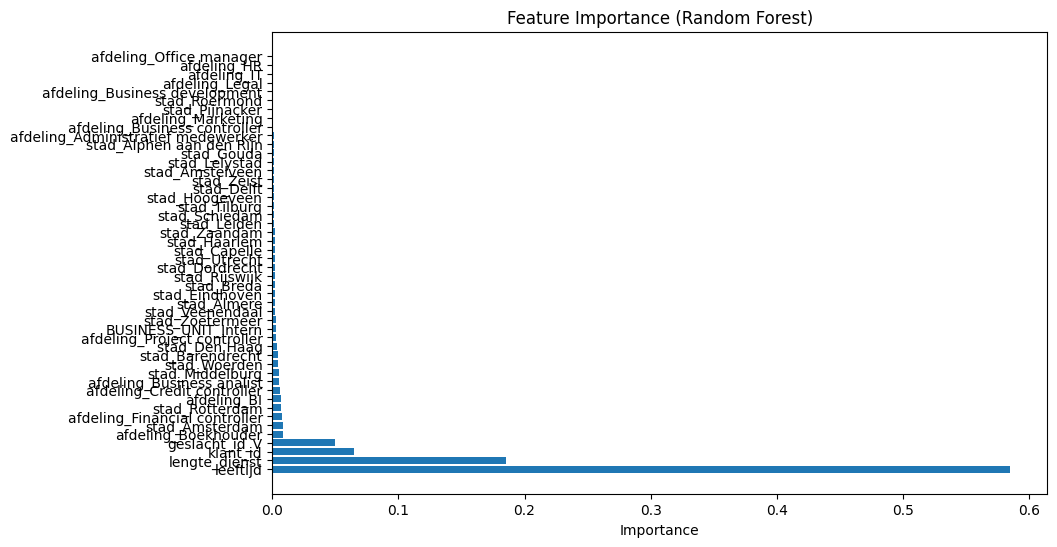

In [29]:
importances = model_RF.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.show()

In [30]:
saved_model_name = 'model_RandomForest_TUNED.joblib'

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_RF_TUNED = loaded_model
else:
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    model_RF_TUNED = grid_search.best_estimator_
    joblib.dump(model_RF_TUNED, saved_model_name)

y_pred = model_RF_TUNED.predict(X_test)

train_score = model_RF_TUNED.score(X_train, y_train)
test_score = model_RF_TUNED.score(X_test, y_test)

params = model_RF_TUNED.get_params()

model_scores['Random Forest Classifier TUNED'] = {
    'Train Score': train_score,
    'Test Score': test_score,
    'Used parameters' : params
}

conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(conf_matrix)



Train Score: 0.9874126928295061
Test Score: 0.9863330318560949
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9660
           1       0.96      0.55      0.70       291

    accuracy                           0.99      9951
   macro avg       0.98      0.78      0.85      9951
weighted avg       0.99      0.99      0.98      9951

Confusion Matrix:
[[9654    6]
 [ 130  161]]


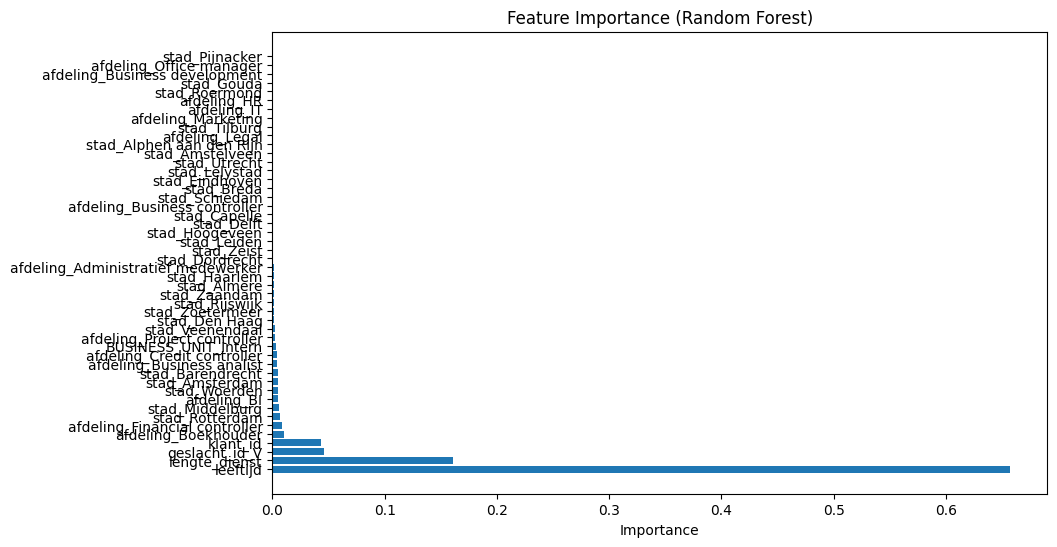

In [31]:
importances = model_RF_TUNED.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.show()

In [35]:
saved_model_name = 'model_svm_classifier_DEFAULT.joblib'

if os.path.exists(saved_model_name):
    model_svm_classifier = joblib.load(saved_model_name)
else:
    model_svm_classifier = SVC()  
    model_svm_classifier.fit(X_train, y_train)
    joblib.dump(model_svm_classifier, saved_model_name)

y_pred = model_svm_classifier.predict(X_test)

train_score = model_svm_classifier.score(X_train, y_train)
test_score = model_svm_classifier.score(X_test, y_test)

params = model_svm_classifier.get_params()

model_scores['SVM Classifier'] = {
    'Train Score': train_score,
    'Test Score': test_score,
    'Used parameters' : params
}

conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_report(y_test, y_pred))


c:\Users\dvana\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning:

Trying to unpickle estimator SVC from version 1.4.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations

c:\Users\dvana\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but SVC was fitted without feature names

c:\Users\dvana\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but SVC was fitted without feature names

c:\Users\dvana\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but SVC was fitted without feature names



Train Score: 0.9699512587307171
Test Score: 0.970756707868556
Confusion Matrix:
[[9660    0]
 [ 291    0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      9660
           1       0.00      0.00      0.00       291

    accuracy                           0.97      9951
   macro avg       0.49      0.50      0.49      9951
weighted avg       0.94      0.97      0.96      9951



c:\Users\dvana\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\dvana\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\dvana\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



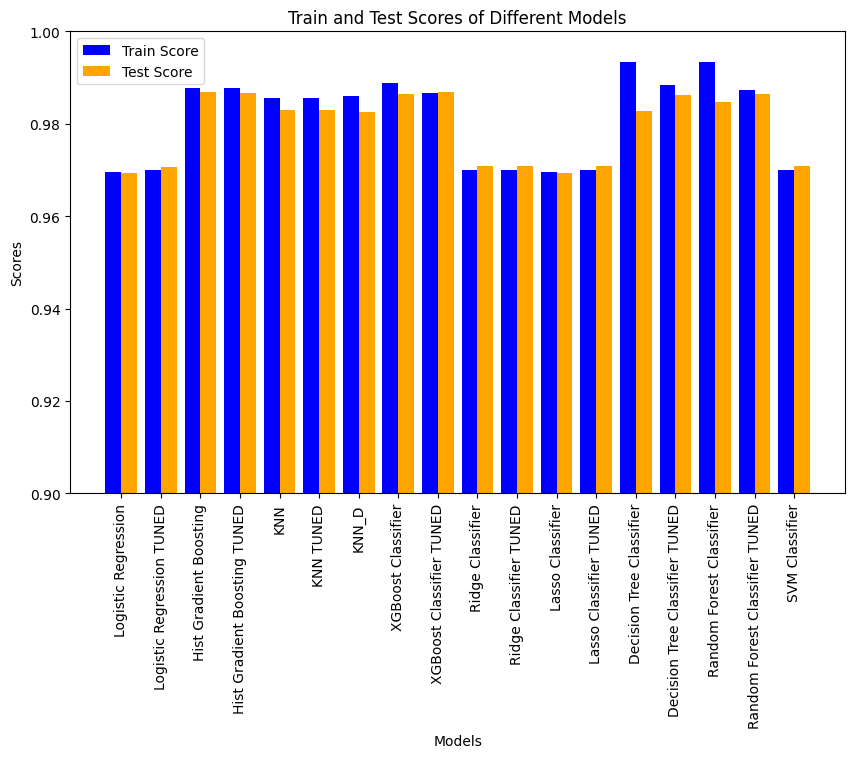

In [36]:
models = list(model_scores.keys())
train_scores = [model_scores[model]["Train Score"] for model in models]
test_scores = [model_scores[model]["Test Score"] for model in models]

x = range(len(models))

plt.figure(figsize=(10, 6))
plt.bar(x, train_scores, width=0.4, label='Train Score', color='b', align='center')
plt.bar([p + 0.4 for p in x], test_scores, width=0.4, label='Test Score', color='orange', align='center')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Train and Test Scores of Different Models')
plt.xticks([p + 0.2 for p in x], models , rotation =90)
plt.ylim(0.9, 1)
plt.legend()
plt.show()


In [39]:
for i in model_scores:
        print(i)
        print(f'Used parameters: {model_scores[i]["Used parameters"]}')

Logistic Regression
Used parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Logistic Regression TUNED
Used parameters: {'C': 0.01, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Hist Gradient Boosting
Used parameters: {'categorical_features': 'warn', 'class_weight': None, 'early_stopping': 'auto', 'interaction_cst': None, 'l2_regularization': 0.0, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_bins': 255, 'max_depth': None, 'max_features': 1.0, 'max_iter': 100, 'max_leaf_nodes': 31, 'min_samples_leaf': 20, 'monotonic_cst': No

KeyError: 'Used parameters'

Find at employees at risk of leaving.

In [38]:
X = df_with_dummies.drop('STATUS_Beëindigd', axis=1)
y = df_with_dummies['STATUS_Beëindigd']

model = RandomForestClassifier()
kf = KFold(n_splits=10)

predicted_vals = []

for i, j in kf.split(X):
    X_train, X_test = X.iloc[i], X.iloc[j]
    y_train, y_test = y.iloc[i], y.iloc[j]
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    predicted_vals.extend(predictions)

df_n_dummies = pd.get_dummies(df , columns=['STATUS'] , drop_first=True)
df['pred_STATUS_Beëindigd'] = predicted_vals

at_risk_employees = df_n_dummies[(df_n_dummies['pred_STATUS_Beëindigd'] == True) & (df_n_dummies['STATUS_Beëindigd'] == False)]
at_risk_employees


KeyError: 'pred_STATUS_Beëindigd'